In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from src.data import pretraining_pipeline
from src.models import get_ASTROMER
from src.utils import get_metrics
import tomli

from sklearn.metrics import r2_score, mean_squared_error

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Experiment logs folder

In [4]:
path_ckpts = f'./presentation/experiments/astromer_0/results_deephub/macho_clean_50_zero-mean_LR1e-05_alpha2/'
path_conf = f'./presentation/experiments/astromer_0/results_deephub/config/macho_clean_50_zero-mean_LR1e-05_alpha2/alcock.100.f0.a.toml'

with open(path_conf, mode="rb") as fp:
    config = tomli.load(fp)     
    
# config

In [5]:
mask_frac = int(config['masking']['mask_frac']*100)

## Testing

In [6]:
# LOADING DATA
BATCH_SIZE = 2500
test_batches = pretraining_pipeline(os.path.join(config['pretraining']['data']['path'], 'test'),
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    config['masking']['mask_frac'],
                                    config['masking']['rnd_frac'],
                                    config['masking']['same_frac'],
                                    sampling=True,
                                    shuffle=True,
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])

d_model = config['astromer']['head_dim']*config['astromer']['heads']
astromer =  get_ASTROMER(num_layers=config['astromer']['layers'],
                         d_model=d_model,
                         num_heads=config['astromer']['heads'],
                         dff=config['astromer']['dff'],
                         base=config['positional']['base'],
                         dropout=config['astromer']['dropout'],
                         maxlen=config['astromer']['window_size'],
                         pe_c=config['positional']['alpha'],
                         no_train=False)

astromer.load_weights(os.path.join(path_ckpts, 'pretraining','weights')).expect_partial()

optimizer = tf.optimizers.Adam(1e-3)
astromer.compile(optimizer=optimizer)
# test_rmse, test_r2 = astromer.evaluate(test_batches)

2023-06-29 03:12:14.099594: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-29 03:12:14.099629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: c5c55004dd7f
2023-06-29 03:12:14.099636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: c5c55004dd7f
2023-06-29 03:12:14.099740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2023-06-29 03:12:14.099758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2023-06-29 03:12:14.099763: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.32.3
2023-06-29 03:12:14.100069: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking
PE_C RECEIVED:  tf.Tensor(2.0, shape=(), dtype=float32)


## Learning curves

In [7]:
test_df = pd.read_csv(os.path.join(path_ckpts, 'pretraining', 'metrics.csv'))
test_metrics = {
    'epoch_loss':test_df[test_df['step']=='pretraining']['rmse'].values[0], 
    'epoch_r_square':test_df[test_df['step']=='pretraining']['r_square'].values[0]
}

# test_metrics = {'epoch_loss':test_rmse, 'epoch_r_square':test_r2}
test_metrics

{'epoch_loss': 0.1034286618232727, 'epoch_r_square': 0.7256374359130859}

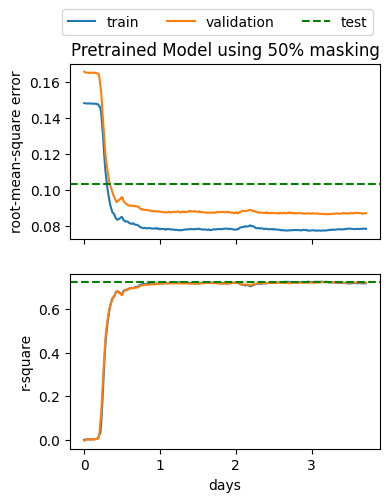

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(4,5), sharex=True)

ft_name_metric = ['rmse', 'r_square']
titles = ['root-mean-square error', 'r-square']
for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    val_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'validation'), 
                           show_keys=False, full_logs=True, metric_name=metric_name)
    
    
    train_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'train'), 
                                 show_keys=False, full_logs=True, metric_name=metric_name, nlog=0)       

    train_logs['wall_time'] = (train_logs['wall_time'] - train_logs['wall_time'].iloc[0])/(60*60*24)
    val_logs['wall_time'] = (val_logs['wall_time'] - val_logs['wall_time'].iloc[0])/(60*60*24)
    
    axes[i].plot(train_logs['wall_time'], train_logs['value'], label='train')
    axes[i].plot(val_logs['wall_time'], val_logs['value'], label='validation')
        
    axes[i].axhline(y=test_metrics[metric_name], color='g', linestyle='--', label='test')
    axes[i].set_ylabel(titles[i])
    
axes[-1].set_xlabel('days')
axes[0].set_title(f'Pretrained Model using {mask_frac}% masking')
axes[0].legend(bbox_to_anchor = (1., 1.35), ncol=3)
# axes[1].set_yticks(np.arange(0, 0.8, 0.1))
plt.show()

## Attention 

In [31]:
# LOADING DATA
BATCH_SIZE = 2500
test_batches = pretraining_pipeline(os.path.join(config['pretraining']['data']['path'], 'test'),
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    config['masking']['mask_frac'],
                                    config['masking']['rnd_frac'],
                                    config['masking']['same_frac'],
                                    sampling=False,
                                    shuffle=False,
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])

[INFO] Repeating dataset x1 times


In [32]:
os.path.join(config['finetuning']['weights'], 'weights')

'./presentation/experiments/astromer_0/results_macho/macho_clean_50_zero-mean_LR1e-05_alpha2/pretraining/weights'

In [33]:
# optimizer = tf.optimizers.Adam(1e-3)
# astromer.compile(optimizer=optimizer)
# test_rmse, test_r2 = astromer.evaluate(test_batches)

In [63]:
x_pred = astromer.predict(test_data)

In [64]:
x_true = tf.concat([y['target'] for _, y in test_data], 0)
x_time = tf.concat([x['times'] for x, _ in test_data], 0)
x_mask = tf.concat([y['mask_out'] for _, y in test_data], 0)

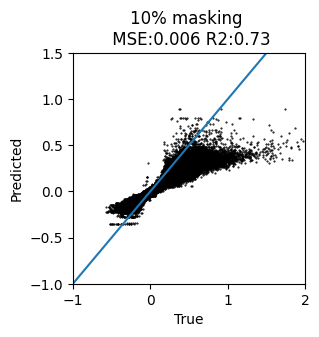

In [65]:
plt.figure(figsize=(3,3), dpi=100)

r2_list,mse_list =[], []
for xp, xt, xm in zip(x_pred, x_true, x_mask):
    xp = tf.boolean_mask(xp, xm)
    xt = tf.boolean_mask(xt, xm)
    
    r2_value = r2_score(xt, xp)
    mse_value = mean_squared_error(xt, xp)
    r2_list.append(r2_value)
    mse_list.append(mse_value)
    plt.scatter(xt, xp, marker='.', s=1, color='k')

plt.plot([-1, 2], [-1, 2])
plt.title("{}% masking \n MSE:{:.3f} R2:{:.2f}".format(mask_frac, np.mean(mse_list), np.mean(r2_list)))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.ylim(-1, 1.5)
plt.xlim(-1, 2)
plt.show()

In [66]:
import numpy as np
from sklearn.metrics import r2_score

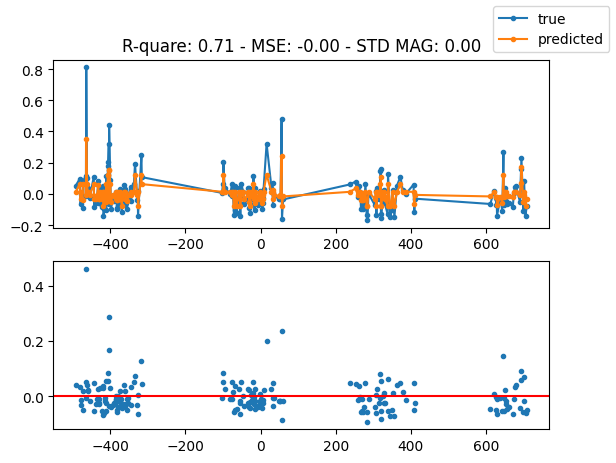

In [67]:
n = np.random.randint(0, len(x_true))

for i in range(n, n+1):
    fig, axes = plt.subplots(2, 1)
    curr_m = x_mask[i]
    curr_x = x_true[i]
    curr_y = x_pred[i]
    curr_t = x_time[i]
    
    curr_x_masked = tf.boolean_mask(curr_x, curr_m)
    curr_y_masked = tf.boolean_mask(curr_y, curr_m)
    curr_t_masked = tf.boolean_mask(curr_t, curr_m)
    
    residuals = curr_x_masked-curr_y_masked
    
    mse = np.mean(residuals)
    std_mag = np.mean(curr_x_masked)
    r2 = r2_score(curr_x, curr_y)
    
    axes[0].set_title('R-quare: {:.2f} - MSE: {:.2f} - STD MAG: {:.2f}'.format(r2, mse, std_mag))
    axes[0].plot(curr_t_masked, curr_x_masked, marker='.', label='true')
    axes[0].plot(curr_t_masked, curr_y_masked, marker='.', label='predicted')
    axes[1].plot(curr_t_masked, residuals, marker='.', linestyle='')
    axes[1].axhline(y=0., color='r', linestyle='-')
    

    fig.legend()

## Attention weights

In [27]:
# LOADING DATA
BATCH_SIZE = 512
print(config['finetuning']['data']['path'])
test_batches = pretraining_pipeline('./data/records/alcock/fold_0/alcock_50/test/',
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    0.,
                                    0.,
                                    0.,
                                    False,
                                    False,
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])
test_data = test_batches.take(1)

./data/records/alcock/fold_0/alcock_100
[INFO] Repeating dataset x1 times


/tmp/ipykernel_24598/485693748.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 199 + 1) instead
  indices_selected = np.random.random_integers(0, len(curr_x)-1, 200)
/tmp/ipykernel_24598/485693748.py:20: RuntimeWarning: divide by zero encountered in log
  axes[1].imshow(np.log(curr_w[0]))


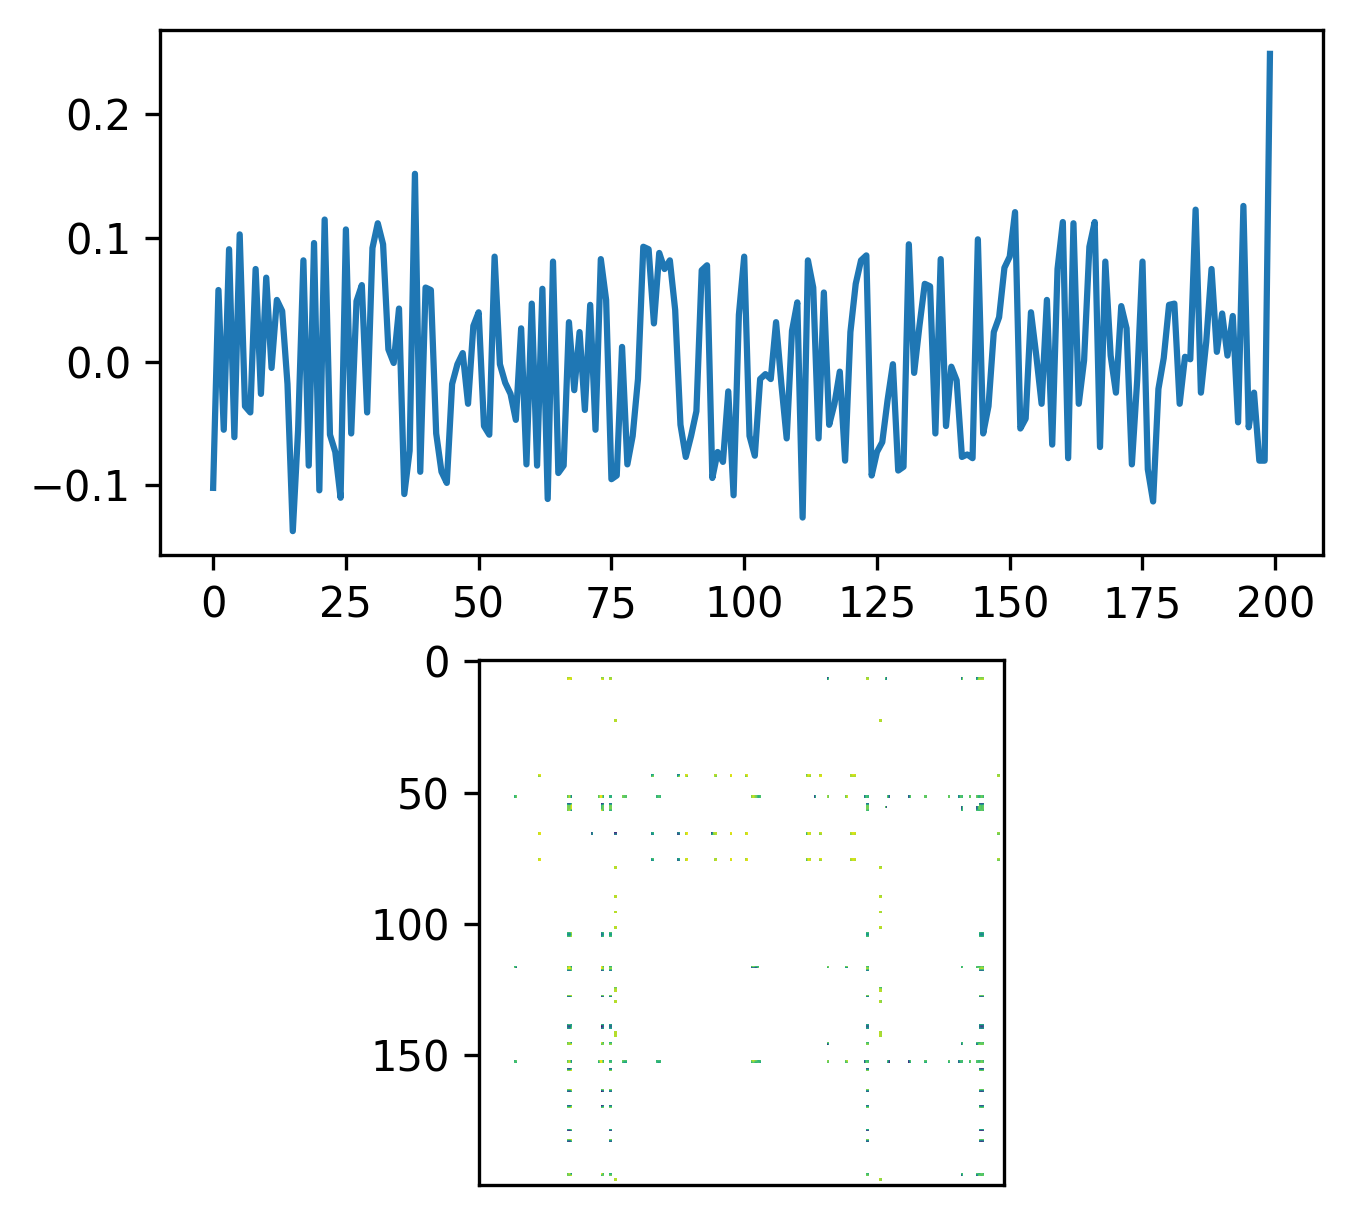

In [36]:
encoder = astromer.get_layer('encoder')

for x, y in test_data:
    output, weights = encoder(x, return_weights=True)    
#     index = np.random.randint(0, output.shape[0])
    index = 500
    curr_w = np.array(weights[index])
    curr_x = np.array(x['input'][index])
    curr_t = np.array(x['times'][index])
        
    indices_selected = np.random.random_integers(0, len(curr_x)-1, 200)
    indices_selected = np.sort(indices_selected)
    
    fig, axes = plt.subplots(2, 1, sharex=False, dpi=300, figsize=(5,5))
    axes[0].plot(curr_x)
#     att_interactive_plot(curr_t[indices_selected], 
#                          curr_x[indices_selected], 
#                          att=curr_w[0][indices_selected])
    
    axes[1].imshow(np.log(curr_w[0]))
    axes[1].set_xticks([])

#     plt.colorbar()
    plt.show()

In [14]:
path_ckpts

'./presentation/experiments/astromer_0/results_old/macho_mask_50_LR1e-05/'

## Classification

In [10]:
import numpy as np 

# to_change = {'a':'b', 'b':'a', 'c':'c'}

clf_metrics = pd.read_csv(os.path.join(path_ckpts, 'alcock', 'classification','metrics.csv'))
# # clf_metrics[clf_metrics['sci_case'] == 'a'].sample()
# clf_metrics['sci_case'] = clf_metrics['sci_case'].apply(lambda x: to_change[x])


,test_precision,test_recall,test_f1,val_acc,val_loss,model,time,fold,sci_case,spc,target
0,0.634821,0.631852,0.631709,0.709534,0.814083,lstm_att,2023-05-18 03:41:58,0,a,100,alcock
1,0.501901,0.508647,0.503295,0.589800,0.995649,lstm,2023-05-18 03:48:52,0,a,100,alcock
2,0.562504,0.555784,0.556192,0.614191,1.020404,mlp_att,2023-05-18 03:50:03,0,a,100,alcock
3,0.486206,0.491160,0.487810,0.673684,0.880046,lstm_att,2023-05-18 04:43:11,0,b,20,alcock
4,0.388270,0.373399,0.370818,0.526316,1.420907,lstm,2023-05-18 04:45:08,0,b,20,alcock
...,...,...,...,...,...,...,...,...,...,...,...
103,0.377234,0.374952,0.366803,0.500000,1.405624,lstm,2023-05-19 06:25:14,2,b,20,alcock
104,0.187556,0.282117,0.201882,0.406250,1.414489,mlp_att,2023-05-19 06:26:16,2,b,20,alcock
105,0.745303,0.747310,0.745701,0.781186,0.658707,lstm_att,2023-05-19 07:18:21,2,c,500,alcock
106,0.666366,0.665108,0.665190,0.701432,0.803082,lstm,2023-05-19 07:41:31,2,c,500,alcock


In [8]:
styles = {'mlp_att':{'marker':'^', 'linestyle':'-', 'name':'MLP+ATT'}, 
          'lstm_att':{'marker':'o', 'linestyle':'--', 'name':'LSTM+ATT'}, 
          'lstm':{'marker':'s', 'linestyle':':', 'name':'Baseline'},
          'mlp_att_conv':{'marker':'.', 'linestyle':'--', 'name':'MLP+ATT+CONV'},
          'mlp_first':{'marker':'*', 'linestyle':':', 'name':'MLP+FIRST'},
          'mlp_last':{'marker':'v', 'linestyle':'-', 'name':'MLP+LAST'},
         }

ft_names_changed = {
    'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'
}
path_ckpts

'./presentation/experiments/astromer_0/results_deephub/macho_clean_50_zero-mean_LR1e-05_alpha2/'

0.506584766814155
0.48741980666607976
0.6099549615281245


Text(0.51, 0.05, 'Samples per class')

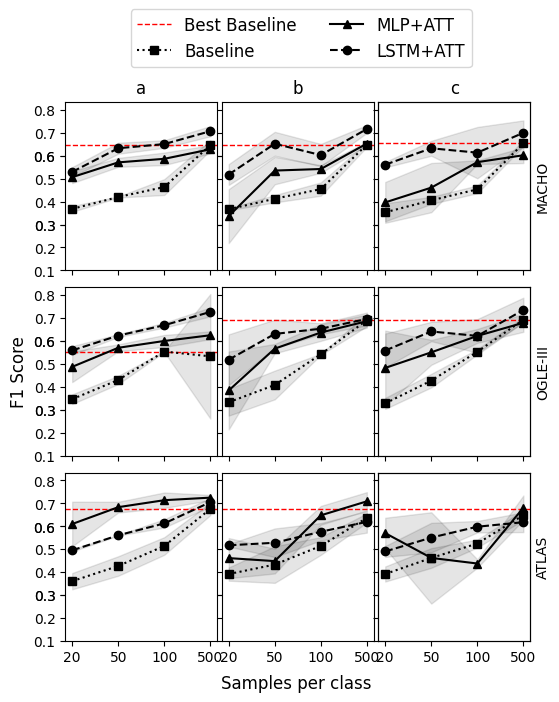

In [15]:
### marker_models = ['s', '^', 'o', 'v']

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6,7), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03})
    
for row, target in enumerate(['alcock', 'ogle', 'atlas']):
    clf_metrics = pd.read_csv(os.path.join(path_ckpts, target, 'classification','metrics.csv'))
    
#     clf_metrics['sci_case'] = clf_metrics['sci_case'].apply(lambda x: to_change[x])

    best_baseline = []
    for col, sci_case in enumerate(['a', 'b', 'c']):
        
        if row == 0:
            axes[row][col].set_title(sci_case)
            
        for model_index, clf_model in enumerate(['lstm', 'mlp_att','lstm_att']):
            partial = clf_metrics[(clf_metrics['target'] == target) & \
                                  (clf_metrics['sci_case'] == sci_case) & \
                                  (clf_metrics['model'] == clf_model)]

            spc_cases, scores_mean, scores_std = [], [], []
            for spc, frame in partial.groupby('spc'):
                spc_cases.append(spc)
                scores_mean.append(frame['test_f1'].mean())
                scores_std.append(frame['test_f1'].std())
            
            x_whole = [20, 50, 100, 500]
            x_range = np.array([x_whole.index(c) for c in spc_cases])

            axes[row][col].errorbar(x_range, scores_mean, 
                               marker=styles[clf_model]['marker'], 
                               label=styles[clf_model]['name'],
                               linestyle=styles[clf_model]['linestyle'],
                               color='k')
            axes[row][col].fill_between(x_range, 
                                       np.array(scores_mean)+np.array(scores_std), 
                                       np.array(scores_mean)-np.array(scores_std),
                                       color='k', alpha=0.1)
            
            axes[row][col].set_xticks(x_range)
            axes[row][col].set_xticklabels([int(x) for x in spc_cases])
            axes[row][col].set_yticks([round(x, 1) for x in np.linspace(0.1, 0.8, 10)])

            if clf_model == 'mlp_att' and sci_case == 'a':
                print(scores_mean[0])
                
            if clf_model == 'lstm':
                best_baseline.append(np.max(scores_mean))
    
        axes[row][col].axhline(y=np.max(best_baseline), 
                               color='red', 
                               linestyle='--', 
                               linewidth=1, 
                               label='Best Baseline')
    
        if col == 2:
            ax2 = axes[row][col].twinx()     
            ax2.set_yticks([])
            ax2.set_ylabel(ft_names_changed[target])

        

axes[1][0].set_ylabel('F1 Score', fontsize=12)
axes[0][1].legend(ncol=2, bbox_to_anchor = (1.7, 1.6), fontsize=12)
fig.text(0.51, 0.05, 'Samples per class', ha='center', va='center', fontsize=12)